
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain wave families
### In this case, two swell systems, one local sea

inputs required: 
  * Historical wave conditions (GOW2 hindcast)
  * Wave families sectors; the split is based on wave direction
  
in this notebook:
  * Split energy based on defined sectors
  * Remove TC associated waves to avoid double counting 


### Workflow:

<div>
<img src="resources/nb01_09.png" width="300px">
</div>


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
from datetime import datetime

# pip
import numpy as np
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.waves import GetDistribution_gow, GetDistribution_ws

# wavespectra
from wavespectra.specdataset import SpecDataset



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_emulator')


In [3]:
# --------------------------------------
# set waves families parameters

_, TCs_r1_params = db.Load_TCs_r1_hist()   # TCs historical parameters inside big radius


# wave families sectors
fams_sectors = [(45, 125), (125, 205)]

# date limits for TCs removal from waves data, and TC time window (hours)
tc_rm_date1 = '1979-01-01'
tc_rm_date2 = '2019-12-31'
tc_time_window = 12


## Calculate Waves Partitions from Waves Spectra (CSIRO + wavespectra) 

In [4]:
# aux.

def fix_dir(base_dirs):
    'fix csiro direction for wavespectra (from -> to)'
    new_dirs = base_dirs + 180
    new_dirs[np.where(new_dirs>=360)] = new_dirs[np.where(new_dirs>=360)] - 360
    
    return new_dirs


In [5]:
# --------------------------------------
# load waves spectra point (CSIRO spec)

WVS_spec = db.Load_WAVES_spectra()

# round to nearest hour
WVS_spec['time'] = WVS_spec['time'].dt.round('H')

# En este fichero de espectros, los datos están duplicados: quedarme sólo con la primera mitad del fichero!!!!!!!
WVS_spec = WVS_spec.isel(time=slice(0,359892))

# direction data fix
WVS_spec['direction'] = fix_dir(WVS_spec['direction'])

# rename variables
WVS_spec = WVS_spec.rename(
    {
        'frequency':'freq',
        'direction':'dir',
        'Efth':'efth',
    }
).set_coords({'freq','dir'})

# efth: rad to º
WVS_spec['efth'] = WVS_spec['efth'] * np.pi/180


# wavespectra parameters
wcut = 0.00000000001  # wcut = 0.3333
#msw = 8
msw = 5 # numero de particiones SWELL
agef = 1.7

# bulk wavespectra
bulk_params = WVS_spec.spec.stats(['hs','tp','tm02','dpm','dspr'])

# partitions
ds_part = WVS_spec.spec.partition(
    WVS_spec.u10m, WVS_spec.udir, WVS_spec.depth, 
    wscut = wcut, max_swells = msw, agefac = agef,
)
WVS_parts = ds_part.spec.stats(['hs','tp','tm02','dpm','dspr']) 

# Add bulk Hs, Tp, Dir variables
WVS_parts['Hs'] = bulk_params['hs']
WVS_parts['Tp'] = bulk_params['tp']
WVS_parts['Dir'] = bulk_params['dpm']

# drop station id
WVS_parts = WVS_parts.drop('station')

# Save partitions data
db.Save_WAVES_partitions(WVS_parts)

print(WVS_parts)


<xarray.Dataset>
Dimensions:  (part: 6, time: 359892)
Coordinates:
  * part     (part) int64 0 1 2 3 4 5
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-01-01
Data variables:
    hs       (part, time) float64 0.0 0.4959 0.7966 1.006 ... 0.0 0.0 0.0 0.0
    tp       (part, time) float64 nan 2.675 3.472 4.061 ... nan nan nan nan
    tm02     (part, time) float64 nan 2.574 3.067 3.422 ... nan nan nan nan
    dpm      (part, time) float64 nan 68.47 69.91 72.29 ... nan nan nan nan
    dspr     (part, time) float64 nan 30.61 29.48 30.17 ... nan nan nan nan
    Hs       (time) float64 0.0 0.4959 0.7966 1.006 ... 2.639 2.692 2.729 2.754
    Tp       (time) float64 nan 2.675 3.472 4.061 ... 13.96 15.61 15.79 15.87
    Dir      (time) float64 nan 68.47 69.91 72.29 ... 340.6 353.5 353.8 354.1
Attributes:
    source:   teslakit_v0.9.1



## Calculate Historical Waves Families (CSIRO + wavespectra)

In [6]:
# --------------------------------------
# Calculate wave families from waves partitions data and waves sectors

WVS_pts = db.Load_WAVES_partitions()       # waves partitions data (from CSIRO spectra and wavespectra toolbox)
print(WVS_pts)
print()

WVS = GetDistribution_ws(WVS_pts, fams_sectors, n_partitions=5)

# Add wavespectra bulk Hs, Tp, Dir variables
WVS['Hs'] = WVS_pts['Hs']
WVS['Tp'] = WVS_pts['Tp']
WVS['Dir'] = WVS_pts['Dir']

# ensure time dimension does not repeat values
_, index = np.unique(WVS['time'], return_index=True)
WVS = WVS.isel(time=index)

print(WVS)


<xarray.Dataset>
Dimensions:  (part: 6, time: 359892)
Coordinates:
  * part     (part) int64 0 1 2 3 4 5
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-01-01
Data variables:
    hs       (part, time) float64 ...
    tp       (part, time) float64 ...
    tm02     (part, time) float64 ...
    dpm      (part, time) float64 ...
    dspr     (part, time) float64 ...
    Hs       (time) float64 ...
    Tp       (time) float64 ...
    Dir      (time) float64 ...
Attributes:
    source:   teslakit_v0.9.1

<xarray.Dataset>
Dimensions:      (time: 359401)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2020-01-01
Data variables:
    sea_Hs       (time) float64 nan 0.4959 0.7966 1.006 ... 2.665 2.702 2.726
    sea_Tp       (time) float64 nan 2.675 3.472 4.061 ... 15.65 15.83 15.91
    sea_Dir      (time) float64 nan 68.47 69.91 72.29 ... 353.2 353.5 353.8
    swell_1_Hs   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_1_Tp  


## TCs: Waves  Selection 

In [7]:
# --------------------------------------
# Locate TCs and set category alongside WAVES data  

# remove TCs before 1979 and after 2020 (r1)
dds = TCs_r1_params.dmin_date.values[:]
ix = np.where((dds >= np.datetime64(tc_rm_date1)) & (dds <= np.datetime64(tc_rm_date2)))[0]
TCs_r1_params = TCs_r1_params.isel(storm=ix)

# select storms inside big circle 
storms_sel = TCs_r1_params.storm.values[:]

# add TCs category alongside WAVES data
WVS['TC_category'] = (('time',), np.empty(len(WVS.time))*np.nan)

for s in storms_sel:

    # waves at storm dates
    ss = TCs_r1_params.sel(storm=s)     
    wvs_s = WVS.sel(time = slice(ss.dmin_date, ss.last_date))
    
    # get hs_max date 
    t_hs_max = wvs_s.where(wvs_s.Hs ==  wvs_s.Hs.max(), drop=True).time.values[:][0]
        
    # hs_max time window 
    w1 = t_hs_max - np.timedelta64(tc_time_window,'h')
    w2 = t_hs_max + np.timedelta64(tc_time_window,'h')
    
    # set category alongside WAVES data
    ixs = np.where((WVS.time >= w1) & (WVS.time <= w2))[0]
    WVS['TC_category'][ixs] = ss.category 
    
print(WVS)

# Store historical WAVES data
db.Save_WAVES_hist(WVS)


<xarray.Dataset>
Dimensions:      (time: 359401)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2020-01-01
Data variables:
    sea_Hs       (time) float64 nan 0.4959 0.7966 1.006 ... 2.665 2.702 2.726
    sea_Tp       (time) float64 nan 2.675 3.472 4.061 ... 15.65 15.83 15.91
    sea_Dir      (time) float64 nan 68.47 69.91 72.29 ... 353.2 353.5 353.8
    swell_1_Hs   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_1_Tp   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_1_Dir  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_2_Hs   (time) float64 nan nan nan nan ... 0.3792 0.3801 0.3833 0.3897
    swell_2_Tp   (time) float64 nan nan nan nan nan ... 10.82 10.8 11.83 11.9
    swell_2_Dir  (time) float64 nan nan nan nan nan ... 164.3 164.1 168.3 168.8
    Hs           (time) float64 ...
    Tp           (time) float64 ...
    Dir          (time) float64 ...
    TC_category  (time) float64 nan nan n

In [5]:
# --------------------------------------
# Particiones obtenidas por AlbaR, sin energía del sector N

WVS_pts_albaR = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_offshore_historical_swells_MDA/wave_partitions_noN.nc')

WVS_albaR = GetDistribution_ws(WVS_pts_albaR, fams_sectors, n_partitions=5)

print(WVS_pts_albaR)
print()

# ensure time dimension does not repeat values
_, index = np.unique(WVS_albaR['time'], return_index=True)
WVS_albaR = WVS_albaR.isel(time=index)
print(WVS_albaR)

# add TC category
WVS_albaR['TC_category'] = WVS.TC_category 

# save fammilies
WVS_albaR.to_netcdf('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_offshore_historical_swells_MDA/waves_historical_albaR.nc')


<xarray.Dataset>
Dimensions:  (part: 6, time: 359401)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2020-01-01
  * part     (part) int64 0 1 2 3 4 5
Data variables:
    hs       (part, time) float32 ...
    tp       (part, time) float64 ...
    tm02     (part, time) float32 ...
    dpm      (part, time) float64 ...
    dspr     (part, time) float32 ...
    sw       (part, time) float32 ...

<xarray.Dataset>
Dimensions:      (time: 359401)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2020-01-01
Data variables:
    sea_Hs       (time) float32 nan 0.495893 0.796626 ... 2.7024312 2.7258103
    sea_Tp       (time) float64 nan 2.675 3.472 4.061 ... 6.674 15.83 15.91
    sea_Dir      (time) float64 nan 68.47 69.91 72.29 ... 55.58 353.5 353.8
    swell_1_Hs   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_1_Tp   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_1_Dir  (time) float64 nan nan nan nan nan nan 

nans sea
12436
29744

nans swell 1
233617
217686

nans swell 2
4129
3692


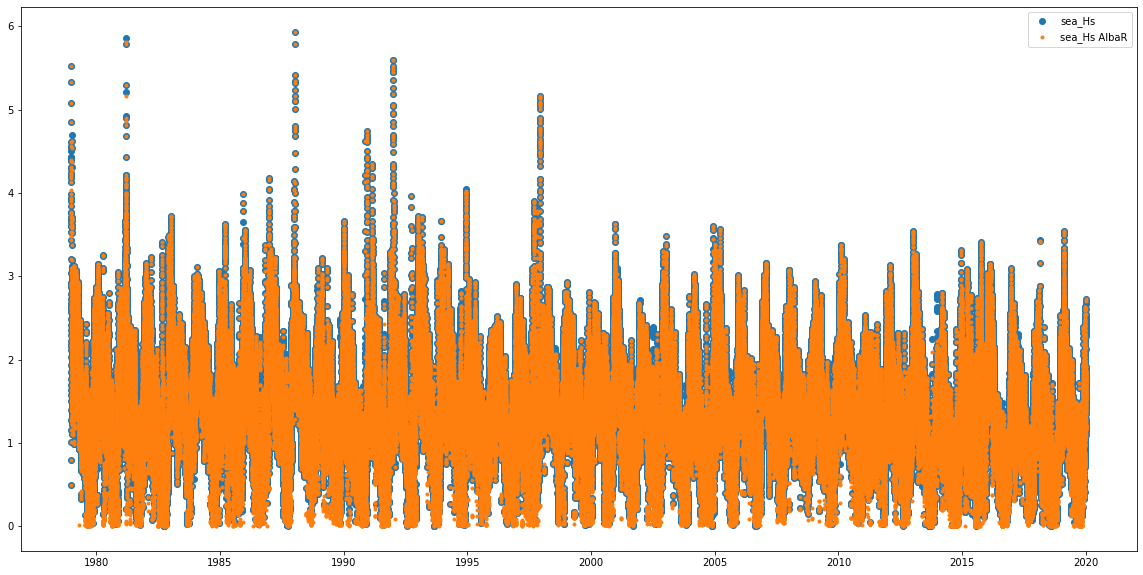

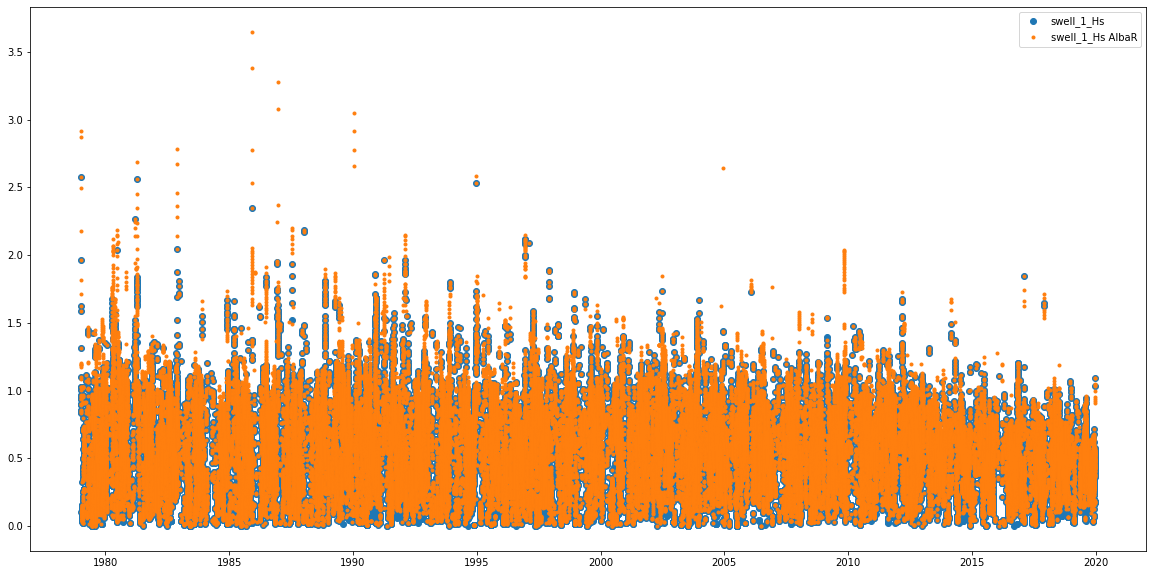

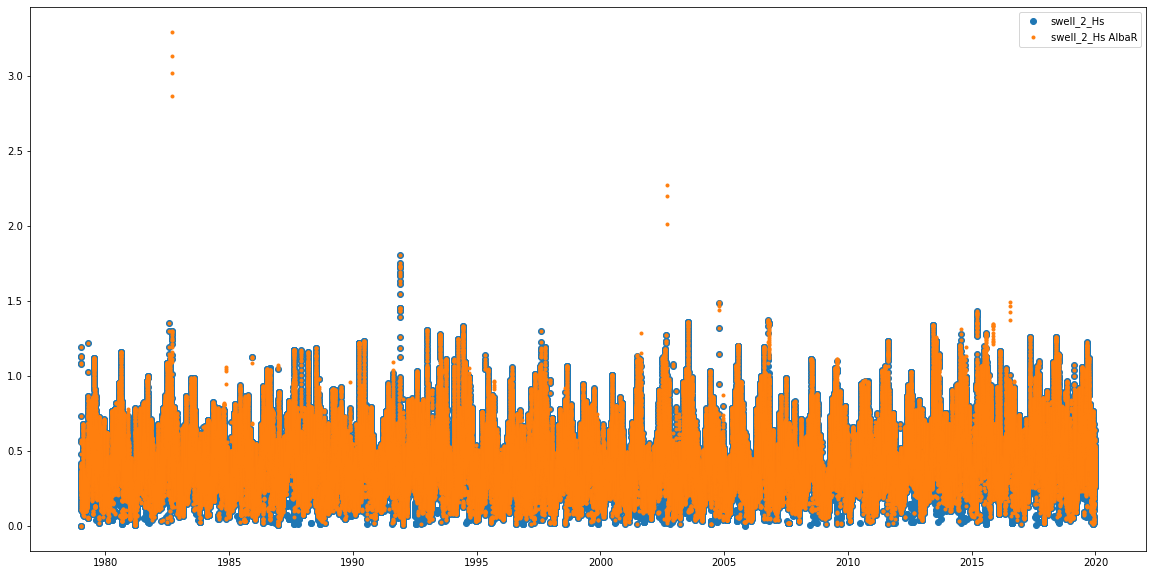

In [6]:
# Compara las familias que salen de este notebook con las familias que obtengo de las particiones de AlbaR

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(WVS.time, WVS.sea_Hs, 'o', label='sea_Hs')
plt.plot(WVS_albaR.time, WVS_albaR.sea_Hs, '.', label='sea_Hs AlbaR')
plt.legend()
#plt.xlim(datetime(1980,1,1), datetime(1983,1,1))

plt.figure(figsize=(20,10))
plt.plot(WVS.time, WVS.swell_1_Hs, 'o', label='swell_1_Hs')
plt.plot(WVS_albaR.time, WVS_albaR.swell_1_Hs, '.', label='swell_1_Hs AlbaR')
plt.legend()
#plt.xlim(datetime(1980,1,1), datetime(1983,1,1))

plt.figure(figsize=(20,10))
plt.plot(WVS.time, WVS.swell_2_Hs, 'o', label='swell_2_Hs')
plt.plot(WVS_albaR.time, WVS_albaR.swell_2_Hs, '.', label='swell_2_Hs AlbaR')
plt.legend()
#plt.xlim(datetime(1980,1,1), datetime(1983,1,1))

print('nans sea')
print(len(WVS.sea_Hs.where(np.isnan(WVS.sea_Hs), drop=True)))
print(len(WVS_albaR.sea_Hs.where(np.isnan(WVS_albaR.sea_Hs), drop=True)))
print()
print('nans swell 1')
print(len(WVS.swell_1_Hs.where(np.isnan(WVS.swell_1_Hs), drop=True)))
print(len(WVS_albaR.swell_1_Hs.where(np.isnan(WVS_albaR.swell_1_Hs), drop=True)))
print()
print('nans swell 2')
print(len(WVS.swell_2_Hs.where(np.isnan(WVS.swell_2_Hs), drop=True)))
print(len(WVS_albaR.swell_2_Hs.where(np.isnan(WVS_albaR.swell_2_Hs), drop=True)))